In [1]:
import argparse
import json
import os
import warnings
import sys
sys.path.append("/Users/ppruthi/research/compositional_models/compositional_models_cate")

import pandas as pd
from sklearn.metrics import r2_score

from domains.samplers import SyntheticDataSampler
from models.MoE import MoE, MoELinear
from models.MoE import *
from models.utils import *
from models.additive_parallel_comp_model import get_additive_model_effects
warnings.filterwarnings('ignore')

def parse_arguments():
    parser = argparse.ArgumentParser(description="Train modular neural network architectures and baselines for causal effect estimation")
    parser.add_argument("--domain", type=str, default="synthetic_data", help="Domain")
    parser.add_argument("--biasing_covariate", type=str, default="feature_sum", help="Biasing covariate")
    parser.add_argument("--bias_strength", type=float, default=0, help="Bias strength")
    parser.add_argument("--scale", type=bool, default=True, help="Scale data")
    parser.add_argument("--num_modules", type=int, default=10, help="Number of modules")
    parser.add_argument("--num_feature_dimensions", type=int, default=100, help="Number of feature dimensions")
    parser.add_argument("--num_samples", type=int, default=10000, help="Number of samples")
    parser.add_argument("--module_function_type", type=str, default="mlp", help="Module function type")
    parser.add_argument("--composition_type", type=str, default="parallel", help="Composition type")
    parser.add_argument("--resample", type=bool, default=False, help="Resample data")
    parser.add_argument("--seed", type=int, default=42, help="Seed for reproducibility")
    parser.add_argument("--fixed_structure", type=bool, default=True, help="Fixed structure flag")
    parser.add_argument("--data_dist", type=str, default="normal", help="Data distribution")
    parser.add_argument("--heterogeneity", type=float, default=1.0, help="Heterogeneity")
    parser.add_argument("--split_type", type=str, default="iid", help="Split type")
    # hidden_dim
    parser.add_argument("--hidden_dim", type=int, default=64, help="Hidden dimension")
    # epochs
    parser.add_argument("--epochs", type=int, default=100, help="Number of epochs")
    # batch_size
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    # output_dim
    parser.add_argument("--output_dim", type=int, default=1, help="Output dimension")
    # covariates_shared
    parser.add_argument("--covariates_shared", type=bool, default=True, help="Covariates shared")
    # model_class
    parser.add_argument("--underlying_model_class", type=str, default="MLP", help="Model class")
    # run_env
    parser.add_argument("--run_env", type=str, default="local", help="Run environment")
    # use_subset_features
    parser.add_argument("--use_subset_features", type=bool, default=False, help="Use subset features")
    # generate trees systematically for creating OOD data
    parser.add_argument("--systematic", type=bool, default=False, help="Generate trees systematically")
    return parser.parse_args(args=[])

def setup_directories(args):
    base_dir = "/Users/ppruthi/research/compositional_models/compositional_models_cate/domains" if args.run_env == "local" else "/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains"
    main_dir = f"{base_dir}/{args.domain}"
    csv_path = f"{main_dir}/csvs/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    obs_data_path = f"{main_dir}/observational_data/fixed_structure_{args.fixed_structure}_outcomes_{args.composition_type}_systematic_{args.systematic}"
    scaler_path = f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/{args.split_type}/scalers"
    return main_dir, csv_path, obs_data_path, scaler_path

def simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path):
    if args.resample:
        sampler.simulate_data()
        sampler.create_observational_data(biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
        sampler.create_iid_ood_split(split_type=args.split_type)
        sampler.create_scalers(args.split_type, biasing_covariate=args.biasing_covariate, bias_strength=args.bias_strength)
    data = pd.read_csv(f"{csv_path}/{args.domain}_data_high_level_features.csv")
    df_sampled = pd.read_csv(f"{obs_data_path}/{args.biasing_covariate}_{args.bias_strength}/df_sampled.csv")
    if args.scale:
        data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path)
    
    
    return data, df_sampled

def load_train_test_data(csv_path, args, df_sampled):
    with open(f"{csv_path}/{args.split_type}/train_test_split_qids.json", "r") as f:
        train_test_qids = json.load(f)
    train_qids, test_qids = train_test_qids["train"], train_test_qids["test"]
    train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
    test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]
    return train_df, test_df, train_qids, test_qids

def train_and_evaluate_model(model, train_df, test_df, covariates, treatment, outcome, epochs, batch_size, train_qids, test_qids):
    model, _, _ = train_model(model, train_df, covariates, treatment, outcome, epochs, batch_size)
    train_estimates = predict_model(model, train_df, covariates)
    test_estimates = predict_model(model, test_df, covariates)
    train_df.loc[:, "estimated_effect"] = train_estimates
    test_df.loc[:, "estimated_effect"] = test_estimates
    estimated_effects_train = get_estimated_effects(train_df, train_qids)
    estimated_effects_test = get_estimated_effects(test_df, test_qids)
    return estimated_effects_train, estimated_effects_test

def calculate_metrics(gt_effects, estimated_effects):
    pehe_score = pehe(gt_effects, estimated_effects)
    r2_score_val = r2_score(gt_effects, estimated_effects)
    return pehe_score, r2_score_val

In [2]:
args = parse_arguments()
main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)

sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, args.module_function_type, resample=args.resample, 
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env)

data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path)
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)



num_modules:  10
(20000, 1024)
train depths:  []
test depths:  [10]
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
module_df shape:  (20000, 103)
['module_9_feature_feature_0', 'module_9_feature_feature_1', 'module_9_feature_feature_2', 'module_9_feature_feature_3', 'module_9_feature_feature_4', 'module_9_feature_feature_5', 'module_9_feature_feature_6', 'module_9_feature_feature_7', 'module_9_feature_feature_8', 'module_9_feature_feature_9', 'module_9_feature_feature_10', 'module_9_feature_feature_11', 'module_9_feature_feature_12', 'module_9_feature_feature_13', 'module_9_feature_feature_14', 'module_9_feature_feature_15', 'module_9_feature_feature_16', 'module_9_feature_feature_17', 'module_9_feature_feature_18', 'module_9_feature_feature_19', 'module_9_f

In [3]:
covariates = [x for x in train_df.columns if "module_1_feature" in x] if args.covariates_shared else [x for x in train_df.columns if "feature" in x]
treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)

input_dim = len(covariates)
models = {
    "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel,
    "MoE": MoE if args.underlying_model_class == "MLP" else MoELinear
}

results = {}
for model_name, model_class in models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim)
    else:
        model = model_class(input_dim + 1, (input_dim + 1) * 2, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs, args.batch_size, train_qids, test_qids
    )
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    
print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path
)
results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"])

# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}_scale_{args.scale}.json", "w") as f:
    json.dump(results, f)

results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")

Training Baseline Model
Training the model on cpu
Training MoE Model
Training the model on cpu
Training Additive Model


FileNotFoundError: [Errno 2] No such file or directory: 'None/input_scaler_9.pkl'

In [4]:
print("Training Additive Model")
additive_combined_train_df, additive_combined_test_df, module_csvs = get_additive_model_effects(
    csv_path, obs_data_path, train_qids, test_qids, hidden_dim=args.hidden_dim, epochs=args.epochs, 
    batch_size=args.batch_size, output_dim=args.output_dim, underlying_model_class=args.underlying_model_class, scale=args.scale, scaler_path=scaler_path
)
results["Additive_train"] = calculate_metrics(additive_combined_train_df["ground_truth_effect"], additive_combined_train_df["estimated_effect"])
results["Additive_test"] = calculate_metrics(additive_combined_test_df["ground_truth_effect"], additive_combined_test_df["estimated_effect"])

# Save results and CSVs
results_path = f"{main_dir}/results/results_{args.data_dist}_{args.module_function_type}_{args.composition_type}_covariates_shared_{args.covariates_shared}_underlying_model_{args.underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{args.systematic}"
os.makedirs(results_path, exist_ok=True)
with open(f"{results_path}/results_{args.num_modules}_{args.num_feature_dimensions}.json", "w") as f:
    json.dump(results, f)

results_csv_folder = f"{main_dir}/results/csvs"
os.makedirs(results_csv_folder, exist_ok=True)
# Save combined_df_test and module_csvs here

print(f"Results saved at {results_path}")
print(f"CSVs saved at {results_csv_folder}")

Training Additive Model
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Training the model on cpu
Results saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/results_normal_mlp_parallel_covariates_shared_True_underlying_model_MLP_use_subset_features_False_systematic_False
CSVs saved at /Users/ppruthi/research/compositional_models/compositional_models_cate/domains/synthetic_data/results/csvs


In [6]:
additive_combined_test_df

,ground_truth_effect,estimated_effect
3,4.623727,6.065973
19,4.492767,2.922044
57,2.451609,3.214866
78,3.035216,3.308708
108,-0.302017,1.196630
...,...,...
9903,-0.474837,1.286526
9933,1.722239,0.364573
9946,0.885192,1.537201
9960,3.543346,3.086866


In [7]:
gt_effects_test_values

array([ 4.62372697e+00,  4.49276679e+00,  2.45160936e+00,  3.03521572e+00,
       -3.02017153e-01,  7.52672288e+00,  1.14684364e+00,  1.00235311e+01,
        7.65722310e-01,  2.60870918e+00,  4.58128595e+00,  1.38315751e+00,
        4.34986010e+00,  3.42892545e+00, -1.75824779e-01,  9.48651324e+00,
        4.97934291e+00,  1.68160994e-01, -9.77236341e-01,  1.23562824e+00,
        1.24615790e+00,  4.64534293e+00,  1.47276288e+00,  1.05902787e+00,
        1.41546690e+00,  1.31517834e+00,  6.20357570e+00,  5.70197667e+00,
        3.86014454e+00,  2.81871677e+00,  1.28691549e+00, -1.24049683e+00,
        1.03556074e+00,  2.75571042e+00,  2.28449195e+00,  4.72446251e-01,
        2.44908374e+00,  3.96189665e+00, -1.63694606e+00,  3.83843333e+00,
        4.91680803e+00,  2.92191258e+00,  1.71485120e+00,  1.04166165e+00,
        1.11043890e+01,  3.33177577e+00,  1.65164520e+00,  9.97670072e+00,
        1.29981637e+00,  1.50603157e+00,  2.98675718e+00,  1.23201026e+00,
       -1.56007860e+00,  

# Results Analysis

In [22]:
def scatter_plot(df, x, y, title, xlabel, ylabel, save_path=None):
    plt.scatter(df[x], df[y])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [20]:
## Confirming risk decomposition of the additive parallel composition model. 
results_csv_folder = f"{main_dir}/results/csvs"
hl_filepath = f"{results_csv_folder}/combined_df_{data_dist}_{module_function_type}_{composition_type}_covariates_shared_{covariates_shared}_underlying_model_{underlying_model_class}_use_subset_features_{args.use_subset_features}_systematic_{systematic}.csv"
combined_df_test = pd.read_csv(hl_filepath)
# drop unnamed columns
high_level_pehe = high_level_pehe.loc[:, ~high_level_pehe.columns.str.contains('^Unnamed')]
pehe_baseline_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
pehe_additive_test = pehe(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
pehe_moe_test = pehe(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"PEHE Baseline: {pehe_baseline_test}")   
print(f"PEHE Additive: {pehe_additive_test}")
print(f"PEHE MoE: {pehe_moe_test}")

# R2 score
r2_baseline_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_baseline"])
r2_additive_test = r2_score(combined_df_test["ground_truth_effect_additive"], combined_df_test["estimated_effect_additive"])
r2_moe_test = r2_score(combined_df_test["ground_truth_effect_baseline"], combined_df_test["estimated_effect_moe"])

print(f"R2 Baseline: {r2_baseline_test}")
print(f"R2 Additive: {r2_additive_test}")
print(f"R2 MoE: {r2_moe_test}")

# scatter plot
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_baseline", "Baseline", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_additive", "estimated_effect_additive", "Additive", "Ground Truth Effect", "Estimated Effect", save_path=None)
scatter_plot(combined_df_test, "ground_truth_effect_baseline", "estimated_effect_moe", "MoE", "Ground Truth Effect", "Estimated Effect", save_path=None)


FileNotFoundError: [Errno 2] No such file or directory: '/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/results/csvs/combined_df_uniform_mlp_parallel_covariates_shared_True_underlying_model_MLP_use_subset_features_False_systematic_False.csv'

# Data Creation

# Data Analysis

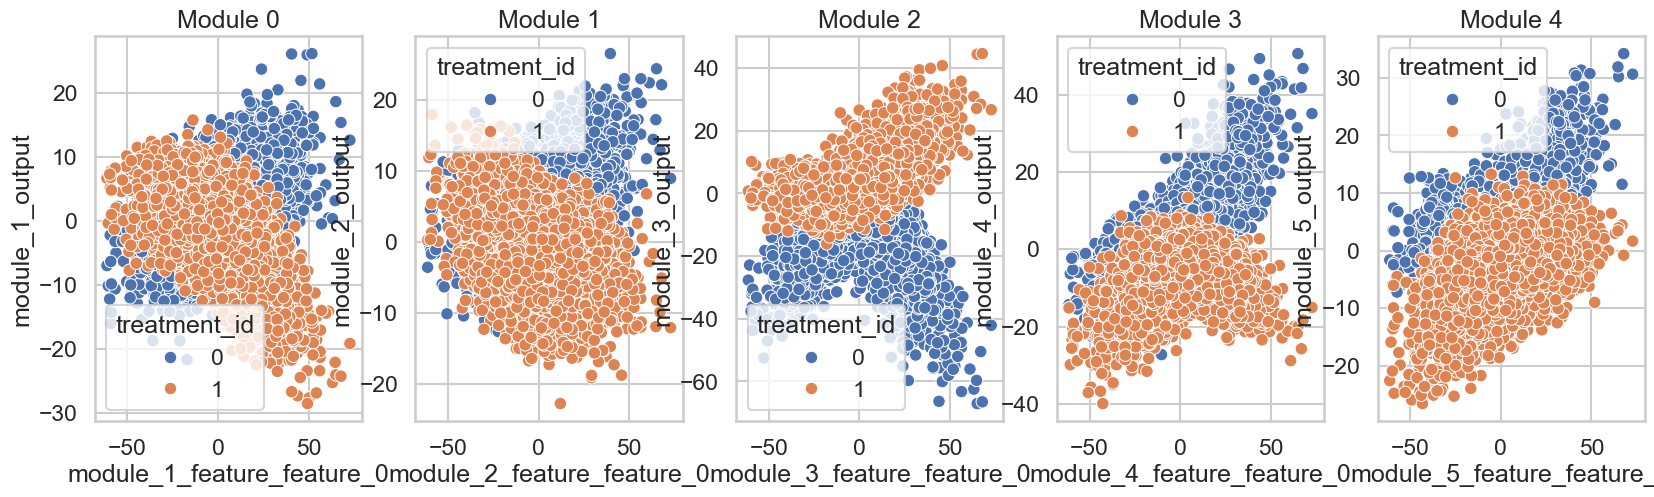

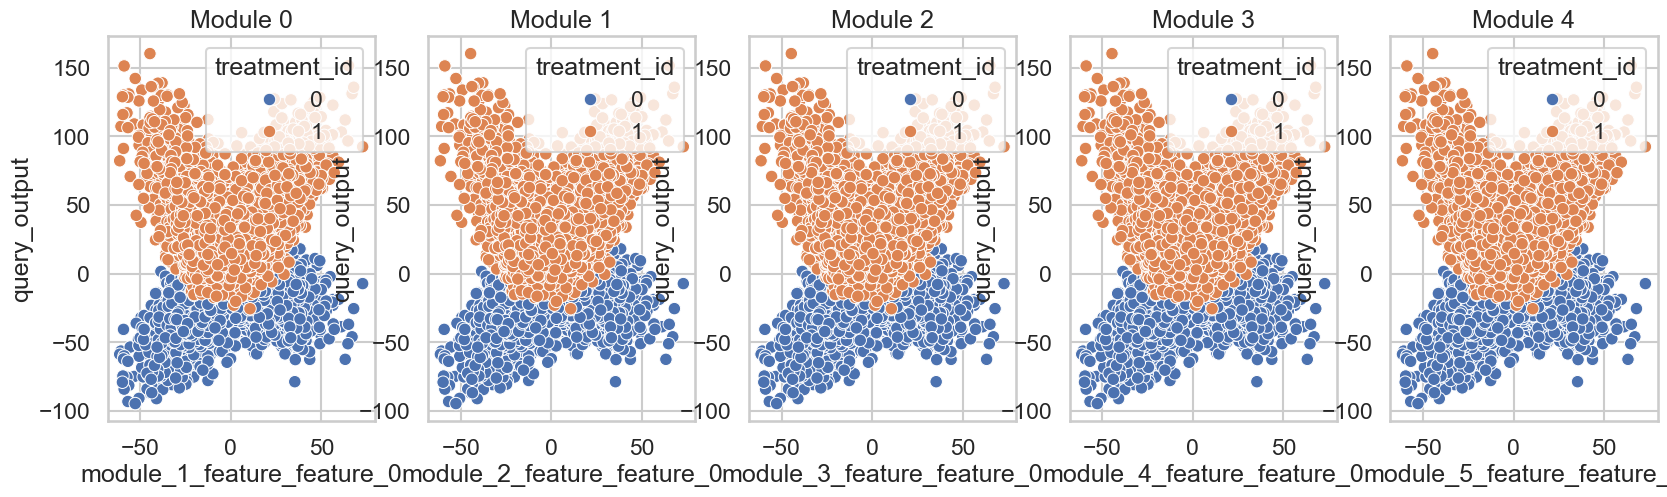

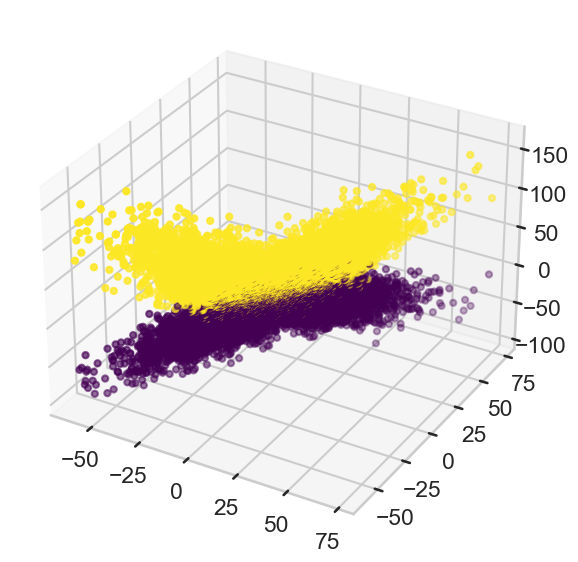

In [8]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
max_modules = 5
fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, max_modules, figsize=(20, 5))
for i in range(max_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["module_2_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



# Observational sampling

# Train/test split

# Data baseline model 

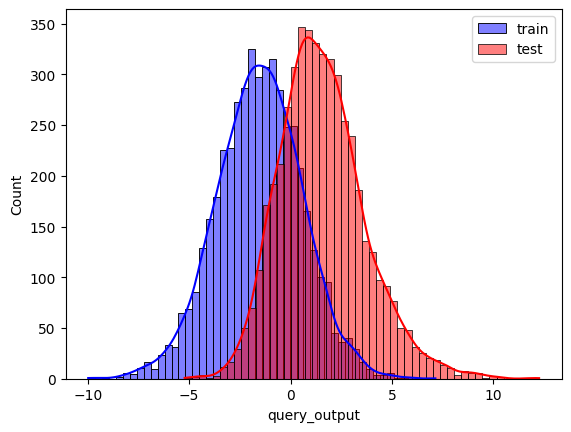

In [5]:
# plot feature distribution of module_1_feature_feature_0
import seaborn as sns
# sns.histplot(train_df[high_level_output], bins=50, color="blue", label="train", kde=True)
# sns.histplot(test_df[high_level_output], bins=50, color="red", label="test", kde=True)

# have two histograms based on treatment
sns.histplot(train_df[train_df["treatment_id"]==0]["query_output"], bins=50, color="blue", label="train", kde=True)
sns.histplot(train_df[train_df["treatment_id"]==1]["query_output"], bins=50, color="red", label="test", kde=True)

plt.legend()




# sns.histplot(data[high_level_output], bins=50, color="green")

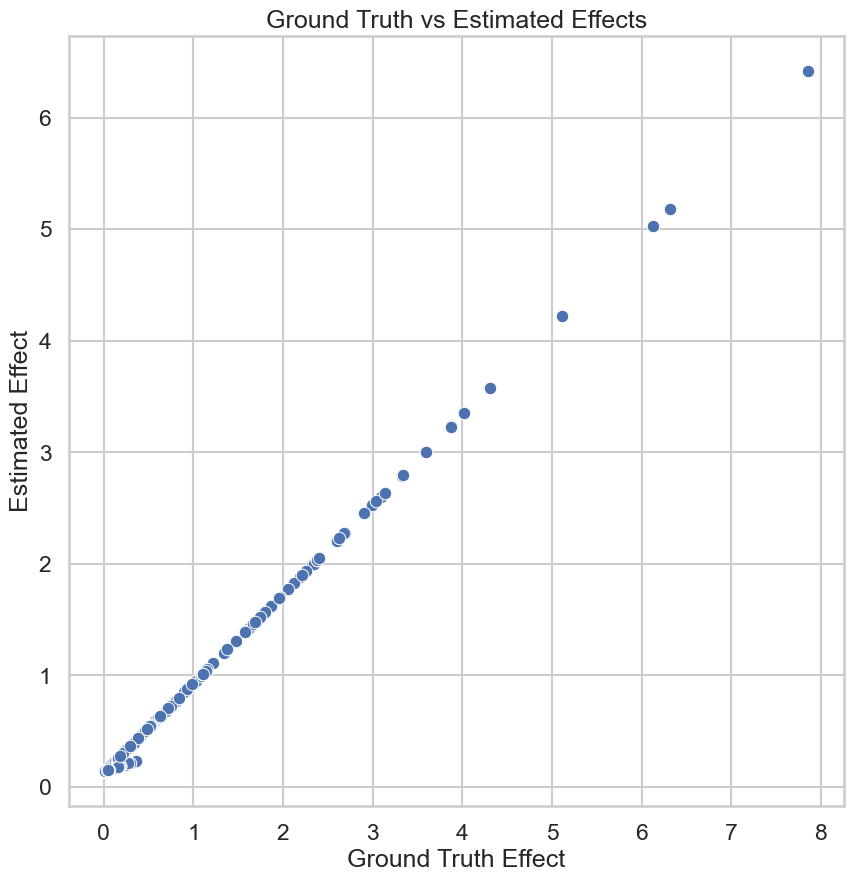

In [55]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

